In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime as dt
from scipy.stats import t
import collections

# import all the tsa functions for AR models, incluant AutoReg
import statsmodels.tsa.ar_model as sma
from statsmodels.tsa.ar_model import AutoReg

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.model_selection import LeaveOneOut, KFold
import warnings

In [2]:
df = pd.read_csv('C:/Users/admin/Downloads/stock_data.csv',parse_dates=['DlyCalDt'],index_col='DlyCalDt')
print(len(df))
df.head()

539767


,Ticker,DlyPrc,DlyRet,DlyVol,vwretd,S&P
DlyCalDt,,,,,,
2019-01-02,AA,26.24,-0.012792,3066951.0,0.001796,0.019857
2019-01-03,AA,26.24,0.000000,2979941.0,-0.021043,0.013227
2019-01-04,AA,28.34,0.080030,5653659.0,0.033410,-0.026963
2019-01-07,AA,28.42,0.002823,2440950.0,0.009202,0.046780
2019-01-08,AA,28.25,-0.005982,2218300.0,0.010269,-0.035806


## Stock returns & S&P500 imports and calculations

In [3]:
df.describe()

,DlyPrc,DlyRet,DlyVol,vwretd,S&P
count,539610.000000,539516.000000,5.396100e+05,539767.000000,539767.000000
mean,42.065340,0.001468,4.158862e+06,0.000881,-0.000002
std,101.518467,0.069282,1.123350e+07,0.017005,0.036655
min,0.022900,-0.917940,0.000000e+00,-0.118168,-3.028410
25%,3.290000,-0.017544,3.637398e+05,-0.003714,-0.008081
50%,13.390000,0.000000,1.206394e+06,0.001418,-0.000631
75%,42.410000,0.016578,3.615343e+06,0.007077,0.006854
max,3225.000000,8.748428,1.003256e+09,0.091556,4.416833


In [4]:
filtered_df = df[df['Ticker'].isin(['MAR', 'SU','AA','AACG','AAL','AAOI','AAPL','AAXN','ABB','ABBV','ABEO','ABEV','ABMD','ABT'])]

# print the filtered dataframe
print(filtered_df)

           Ticker  DlyPrc    DlyRet     DlyVol    vwretd       S&P
DlyCalDt                                                          
2019-01-02     AA   26.24 -0.012792  3066951.0  0.001796  0.019857
2019-01-03     AA   26.24  0.000000  2979941.0 -0.021043  0.013227
2019-01-04     AA   28.34  0.080030  5653659.0  0.033410 -0.026963
2019-01-07     AA   28.42  0.002823  2440950.0  0.009202  0.046780
2019-01-08     AA   28.25 -0.005982  2218300.0  0.010269 -0.035806
...           ...     ...       ...        ...       ...       ...
2020-08-07     SU   16.18 -0.015216  4877202.0  0.000244 -0.008806
2020-08-10     SU   16.91  0.045117  5206803.0  0.002652 -0.005671
2020-08-11     SU   16.96  0.002957  5794876.0 -0.007931 -0.016591
2020-08-12     SU   17.41  0.026533  4012786.0  0.012994 -0.017460
2020-08-13     SU   16.98 -0.024698  3376436.0 -0.000593 -0.000683

[5512 rows x 6 columns]


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Calculate frequency counts for each label
counts = df['Ticker'].value_counts()

# Calculate equal weights for each label based on frequency counts
weights = dict(zip(counts.index, [1 / counts[Ticker] for Ticker in counts.index]))

# Add weights to the dataset
df['weight'] = df['Ticker'].map(weights)

print(df)


           Ticker  DlyPrc    DlyRet      DlyVol    vwretd       S&P    weight
DlyCalDt                                                                     
2019-01-02     AA   26.24 -0.012792   3066951.0  0.001796  0.019857  0.002451
2019-01-03     AA   26.24  0.000000   2979941.0 -0.021043  0.013227  0.002451
2019-01-04     AA   28.34  0.080030   5653659.0  0.033410 -0.026963  0.002451
2019-01-07     AA   28.42  0.002823   2440950.0  0.009202  0.046780  0.002451
2019-01-08     AA   28.25 -0.005982   2218300.0  0.010269 -0.035806  0.002451
...           ...     ...       ...         ...       ...       ...       ...
2020-08-07   TRUE    5.48  0.277389  16589109.0  0.000244 -0.028568  0.002451
2020-08-10   TRUE    5.44 -0.007299   4638210.0  0.002652  0.005649  0.002451
2020-08-11   TRUE    5.04 -0.073529   2476159.0 -0.007931 -0.001321  0.002451
2020-08-12   TRUE    5.10  0.011905   1151840.0  0.012994 -0.006204  0.002451
2020-08-13   TRUE    5.15  0.009804   1159800.0 -0.000593 -0.007

In [6]:
#find frequency of each letter grade
pd.crosstab(index=df['Ticker'], columns='count')

col_0,count
Ticker,
AA,408
AACG,208
AAL,408
AAOI,408
AAPL,408
...,...
ZS,408
ZSAN,408
ZUO,408


In [7]:
 #Define mapping of weights to ticker
weights ={'MAR': 0.4, 'SU': 0.3, 'AA': 0.3,'AACG': 0.3,'AAL': 0.1,'AAOI': 0.2,'AAPL': 0.3,'AAXN': 0.4,'ABB': 0.3,'ABBV': 0.3,'ABEO': 0.6,'ABEV': 0.7,'ABMD': 0.8,'ABT': 0.8,'ABUS': 0.8}
# Create new column 'Category_Code' by mapping 'Category' to numeric codes
filtered_df['portfolio_weights'] = filtered_df['Ticker'].map(weights)
df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_20256\4014762556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['portfolio_weights'] = filtered_df['Ticker'].map(weights)


,Ticker,DlyPrc,DlyRet,DlyVol,vwretd,S&P,weight
DlyCalDt,,,,,,,
2019-01-02,AA,26.24,-0.012792,3066951.0,0.001796,0.019857,0.002451
2019-01-03,AA,26.24,0.000000,2979941.0,-0.021043,0.013227,0.002451
2019-01-04,AA,28.34,0.080030,5653659.0,0.033410,-0.026963,0.002451
2019-01-07,AA,28.42,0.002823,2440950.0,0.009202,0.046780,0.002451
2019-01-08,AA,28.25,-0.005982,2218300.0,0.010269,-0.035806,0.002451


In [8]:
# Create new column 'portfolio returns' by multiplying daily returns and weights
filtered_df['Port_ret'] = filtered_df['DlyRet'] * filtered_df['portfolio_weights']
filtered_df['Port_ret_S&P'] = filtered_df['S&P'] * filtered_df['portfolio_weights']
filtered_df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_20256\4098712371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Port_ret'] = filtered_df['DlyRet'] * filtered_df['portfolio_weights']
C:\Users\admin\AppData\Local\Temp\ipykernel_20256\4098712371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Port_ret_S&P'] = filtered_df['S&P'] * filtered_df['portfolio_weights']


,Ticker,DlyPrc,DlyRet,DlyVol,vwretd,S&P,portfolio_weights,Port_ret,Port_ret_S&P
DlyCalDt,,,,,,,,,
2019-01-02,AA,26.24,-0.012792,3066951.0,0.001796,0.019857,0.3,-0.003837,0.005957
2019-01-03,AA,26.24,0.000000,2979941.0,-0.021043,0.013227,0.3,0.000000,0.003968
2019-01-04,AA,28.34,0.080030,5653659.0,0.033410,-0.026963,0.3,0.024009,-0.008089
2019-01-07,AA,28.42,0.002823,2440950.0,0.009202,0.046780,0.3,0.000847,0.014034
2019-01-08,AA,28.25,-0.005982,2218300.0,0.010269,-0.035806,0.3,-0.001795,-0.010742


In [9]:
# Create new column 'portfolio returns' by multiplying daily returns and weights
df['Port_ret'] = df['DlyRet'] * df['weight']
df['Port_ret_S&P'] = df['S&P'] *df['weight']
df.head()

,Ticker,DlyPrc,DlyRet,DlyVol,vwretd,S&P,weight,Port_ret,Port_ret_S&P
DlyCalDt,,,,,,,,,
2019-01-02,AA,26.24,-0.012792,3066951.0,0.001796,0.019857,0.002451,-0.000031,0.000049
2019-01-03,AA,26.24,0.000000,2979941.0,-0.021043,0.013227,0.002451,0.000000,0.000032
2019-01-04,AA,28.34,0.080030,5653659.0,0.033410,-0.026963,0.002451,0.000196,-0.000066
2019-01-07,AA,28.42,0.002823,2440950.0,0.009202,0.046780,0.002451,0.000007,0.000115
2019-01-08,AA,28.25,-0.005982,2218300.0,0.010269,-0.035806,0.002451,-0.000015,-0.000088


In [10]:
filtered_df.describe()

,DlyPrc,DlyRet,DlyVol,vwretd,S&P,portfolio_weights,Port_ret,Port_ret_S&P
count,5512.000000,5512.000000,5.512000e+03,5512.000000,5512.000000,5512.000000,5512.000000,5512.000000
mean,70.211740,0.000508,9.257811e+06,0.000897,-0.000138,0.418433,0.000226,0.000047
std,83.781039,0.040148,1.818349e+07,0.017133,0.028870,0.216053,0.018541,0.016814
min,0.673000,-0.377000,3.530000e+02,-0.118168,-0.277723,0.100000,-0.226200,-0.105909
25%,11.213750,-0.013533,8.253000e+05,-0.003714,-0.009809,0.300000,-0.004807,-0.003428
50%,31.025000,0.000344,3.171703e+06,0.001457,-0.000756,0.300000,0.000120,-0.000275
75%,89.260000,0.014026,8.340246e+06,0.007077,0.007829,0.600000,0.004931,0.002654
max,460.040000,0.909091,4.283355e+08,0.091556,1.109404,0.800000,0.545455,0.776583


In [11]:
df.describe()

,DlyPrc,DlyRet,DlyVol,vwretd,S&P,weight,Port_ret,Port_ret_S&P
count,539610.000000,539516.000000,5.396100e+05,539767.000000,539767.000000,539767.000000,539516.000000,5.397670e+05
mean,42.065340,0.001468,4.158862e+06,0.000881,-0.000002,0.002571,0.000004,2.952089e-08
std,101.518467,0.069282,1.123350e+07,0.017005,0.036655,0.001978,0.000221,9.922365e-05
min,0.022900,-0.917940,0.000000e+00,-0.118168,-3.028410,0.001225,-0.022167,-7.422575e-03
25%,3.290000,-0.017544,3.637398e+05,-0.003714,-0.008081,0.002451,-0.000044,-2.028936e-05
50%,13.390000,0.000000,1.206394e+06,0.001418,-0.000631,0.002451,0.000000,-1.572150e-06
75%,42.410000,0.016578,3.615343e+06,0.007077,0.006854,0.002451,0.000041,1.720785e-05
max,3225.000000,8.748428,1.003256e+09,0.091556,4.416833,1.000000,0.041985,1.823759e-02


Text(0, 0.5, 'Daily Returns')

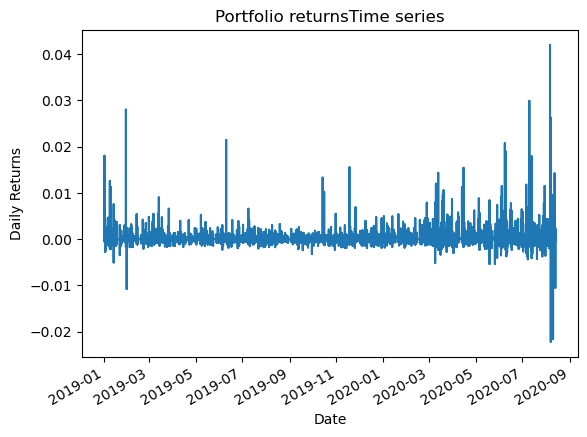

In [12]:
#### Portfolio returns plot
df['Port_ret'].plot()
plt.title('Portfolio returnsTime series')
plt.xlabel('Date')
plt.ylabel('Daily Returns')

Text(0, 0.5, 'Daily Returns')

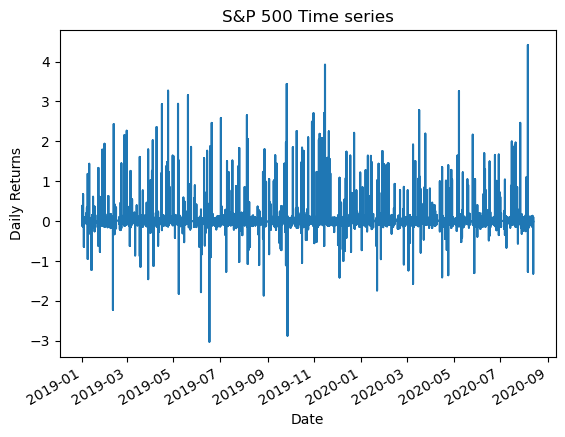

In [13]:
## S&P 500 plot
df['S&P'].plot()
plt.title('S&P 500 Time series')
plt.xlabel('Date')
plt.ylabel('Daily Returns')

## Value at Risk Question 2

In [14]:
# Calculate portfolio log return
returns= filtered_df['Port_ret']
returns.describe()

count    5512.000000
mean        0.000226
std         0.018541
min        -0.226200
25%        -0.004807
50%         0.000120
75%         0.004931
max         0.545455
Name: Port_ret, dtype: float64

In [15]:
# Calculate portfolio log return
returnss= df['Port_ret']
returnss.describe()

count    539516.000000
mean          0.000004
std           0.000221
min          -0.022167
25%          -0.000044
50%           0.000000
75%           0.000041
max           0.041985
Name: Port_ret, dtype: float64

In [16]:
# Value-at-Risk and expected shortfall at the 5% and 1% levels for the portfolio held by RH traders.
from scipy.stats import norm
# Calculate portfolio mean and standard deviation of returns
mu = np.mean(returns)
sigma = np.std(returns)

# Calculate Value-at-Risk (VaR) at the 5% and 1% levels
VaR_5 = norm.ppf(0.05, mu, sigma)
VaR_1 = norm.ppf(0.01, mu, sigma)

# Calculate Expected Shortfall (ES) at the 5% and 1% levels
ES_5 = -mu - sigma * norm.pdf(norm.ppf(0.05)) / 0.05
ES_1 = -mu - sigma * norm.pdf(norm.ppf(0.01)) / 0.01

# Print results
print('VaR at 5% level:', round(VaR_5, 4))
print('VaR at 1% level:', round(VaR_1, 4))
print('ES at 5% level:', round(ES_5, 4))
print('ES at 1% level:', round(ES_1, 4))

VaR at 5% level: -0.0303
VaR at 1% level: -0.0429
ES at 5% level: -0.0385
ES at 1% level: -0.0496


In [17]:
# Value-at-Risk and expected shortfall at the 5% and 1% levels for the portfolio held by RH traders.
from scipy.stats import norm
# Calculate portfolio mean and standard deviation of returns
mu = np.mean(returnss)
sigma = np.std(returnss)

# Calculate Value-at-Risk (VaR) at the 5% and 1% levels
VaR_5 = norm.ppf(0.05, mu, sigma)
VaR_1 = norm.ppf(0.01, mu, sigma)

# Calculate Expected Shortfall (ES) at the 5% and 1% levels
ES_5 = -mu - sigma * norm.pdf(norm.ppf(0.05)) / 0.05
ES_1 = -mu - sigma * norm.pdf(norm.ppf(0.01)) / 0.01

# Print results
print('VaR at 5% level:', round(VaR_5, 4))
print('VaR at 1% level:', round(VaR_1, 4))
print('ES at 5% level:', round(ES_5, 4))
print('ES at 1% level:', round(ES_1, 4))

VaR at 5% level: -0.0004
VaR at 1% level: -0.0005
ES at 5% level: -0.0005
ES at 1% level: -0.0006


In [18]:
sreturn = filtered_df['S&P']
sreturn.describe()

count    5512.000000
mean       -0.000138
std         0.028870
min        -0.277723
25%        -0.009809
50%        -0.000756
75%         0.007829
max         1.109404
Name: S&P, dtype: float64

In [19]:
sreturns = df['S&P']
sreturns.describe()

count    539767.000000
mean         -0.000002
std           0.036655
min          -3.028410
25%          -0.008081
50%          -0.000631
75%           0.006854
max           4.416833
Name: S&P, dtype: float64

In [20]:
# Value-at-Risk and expected shortfall at the 5% and 1% levels for the portfolio held by S&P500 index
from scipy.stats import norm

# Calculate portfolio mean and standard deviation of returns
mu = np.mean(sreturn)
sigma = np.std(sreturn)

# Calculate Value-at-Risk (VaR) at the 5% and 1% levels
VaR_5 = norm.ppf(0.05, mu, sigma)
VaR_1 = norm.ppf(0.01, mu, sigma)

# Calculate Expected Shortfall (ES) at the 5% and 1% levels
ES_5 = -mu - sigma * norm.pdf(norm.ppf(0.05)) / 0.05
ES_1 = -mu - sigma * norm.pdf(norm.ppf(0.01)) / 0.01

# Print results
print('VaR at 5% level:', round(VaR_5, 4))
print('VaR at 1% level:', round(VaR_1, 4))
print('ES at 5% level:', round(ES_5, 4))
print('ES at 1% level:', round(ES_1, 4))

VaR at 5% level: -0.0476
VaR at 1% level: -0.0673
ES at 5% level: -0.0594
ES at 1% level: -0.0768


In [21]:
# Value-at-Risk and expected shortfall at the 5% and 1% levels for the portfolio held by S&P500 index
from scipy.stats import norm

# Calculate portfolio mean and standard deviation of returns
mu = np.mean(sreturns)
sigma = np.std(sreturns)

# Calculate Value-at-Risk (VaR) at the 5% and 1% levels
VaR_5 = norm.ppf(0.05, mu, sigma)
VaR_1 = norm.ppf(0.01, mu, sigma)

# Calculate Expected Shortfall (ES) at the 5% and 1% levels
ES_5 = -mu - sigma * norm.pdf(norm.ppf(0.05)) / 0.05
ES_1 = -mu - sigma * norm.pdf(norm.ppf(0.01)) / 0.01

# Print results
print('VaR at 5% level:', round(VaR_5, 4))
print('VaR at 1% level:', round(VaR_1, 4))
print('ES at 5% level:', round(ES_5, 4))
print('ES at 1% level:', round(ES_1, 4))

VaR at 5% level: -0.0603
VaR at 1% level: -0.0853
ES at 5% level: -0.0756
ES at 1% level: -0.0977


## Rolling Forecasts Question 3

In [24]:
from statsmodels.tsa.stattools import adfuller

df_stationarityTest = adfuller(filtered_df['Port_ret'], autolag='AIC')
df_stationarityTest

(-14.636263097061772,
 3.684206121265392e-27,
 29,
 5482,
 {'1%': -3.431543426607865,
  '5%': -2.8620673757165638,
  '10%': -2.5670507209785174},
 -28243.028873651623)

In [26]:
print('ADF Statistic:', df_stationarityTest[0])
print("P-value: ", df_stationarityTest[1])

ADF Statistic: -14.636263097061772
P-value:  3.684206121265392e-27


C:\Users\admin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


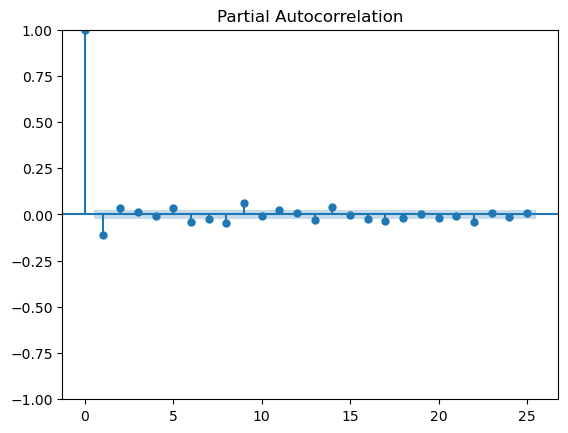

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(filtered_df['Port_ret'], lags=25)

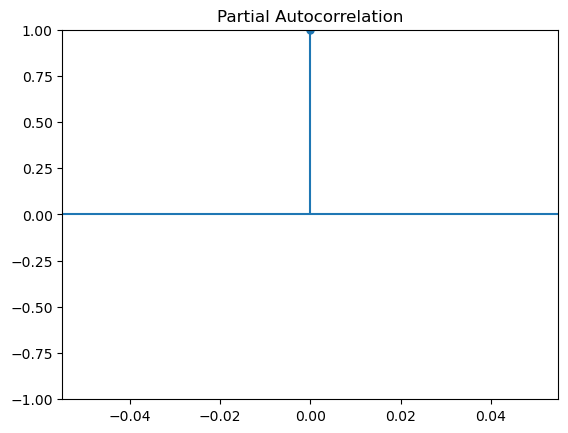

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['Port_ret'], lags=25)

In [29]:
#Create training and test data
#
train_data = filtered_df['Port_ret'][:len(filtered_df)-100]
test_data = filtered_df['Port_ret'][len(filtered_df)-100:]
#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(train_data, lags=8).fit()
#
# Print Summary
#
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:               Port_ret   No. Observations:                 5412
Model:                     AutoReg(8)   Log Likelihood               13914.933
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Tue, 04 Apr 2023   AIC                         -27809.865
Time:                        15:14:27   BIC                         -27743.916
Sample:                             8   HQIC                        -27786.842
                                 5412                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.000      0.900      0.368      -0.000       0.001
Port_ret.L1    -0.1094      0.014     -8.053      0.000      -0.136      -0.083
Port_ret.L2     0.0350      0.014      2.560    

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Text(0, 0.5, 'Daily Returns')

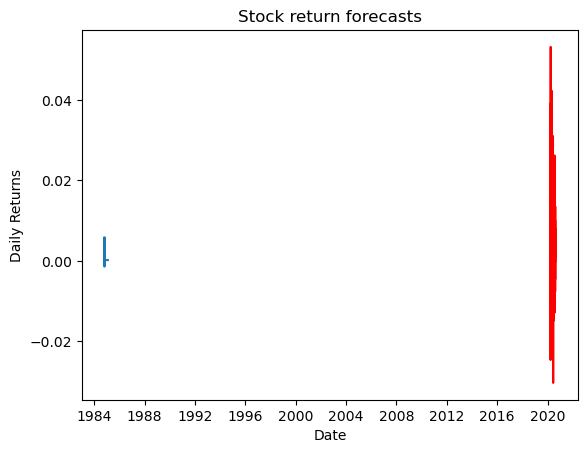

In [30]:
#
# Make the predictions
#
pred = ar_model.predict(start=len(train_data), end=(len(filtered_df)-1), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test_data, color='red')
plt.title('Stock return forecasts')
plt.xlabel('Date')
plt.ylabel('Daily Returns')

                            AutoReg Model Results                             
Dep. Variable:               Port_ret   No. Observations:                 5412
Model:                     AutoReg(8)   Log Likelihood               13914.933
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Tue, 04 Apr 2023   AIC                         -27809.865
Time:                        15:14:29   BIC                         -27743.916
Sample:                             8   HQIC                        -27786.842
                                 5412                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.000      0.900      0.368      -0.000       0.001
Port_ret.L1    -0.1094      0.014     -8.053      0.000      -0.136      -0.083
Port_ret.L2     0.0350      0.014      2.560    

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0, 0.5, 'Daily Returns')

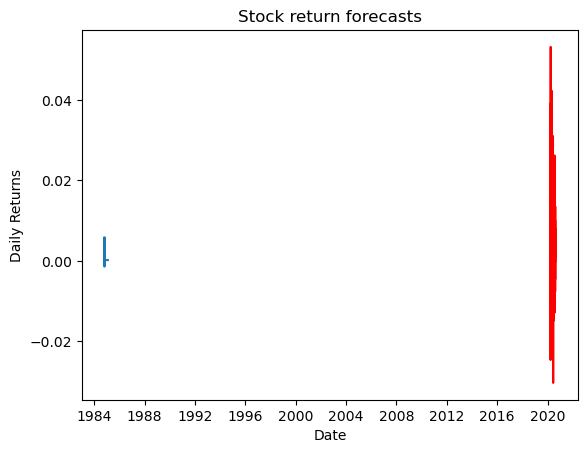

In [31]:

from matplotlib import pyplot

ar_model = AutoReg(train_data, lags=8).fit()
#
# Print Summary
#
print(ar_model.summary())
pyplot.plot(pred)
pyplot.plot(test_data, color='red')
plt.title('Stock return forecasts')
plt.xlabel('Date')
plt.ylabel('Daily Returns')



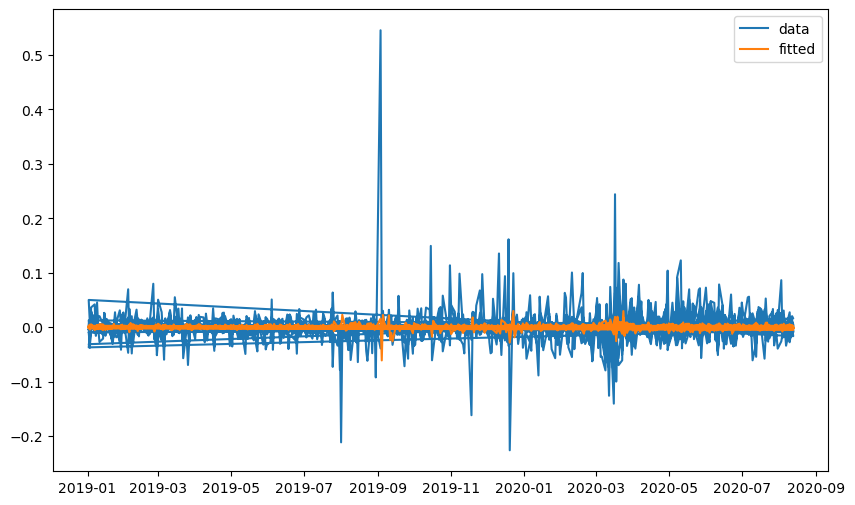

In [32]:
# calculate the 90% confidence interval
ci = ar_model.conf_int(alpha=0.1)
# plot the data and the confidence interval
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(filtered_df['Port_ret'], label='data')
ax.plot(ar_model.fittedvalues, label='fitted')
ax.legend()


In [33]:
ci.describe()

,0,1
count,9.000000,9.000000
mean,-0.036655,0.003364
std,0.047817,0.045896
min,-0.131784,-0.087080
25%,-0.064420,-0.019418
50%,-0.028062,0.000638
75%,-0.000187,0.036660
max,0.013437,0.058397


In [36]:
# Generate forecasts for the next 10 time periods
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecast_values = ar_model.predict(start=len(filtered_df), end=len(filtered_df)+9)

# Print a summary of the forecast's statistics
print('Mean forecast value:', forecast_values.mean())
print('Standard deviation of forecast values:', forecast_values.std())



Mean forecast value: 0.00019625816439815431
Standard deviation of forecast values: 9.307287856152525e-18


C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [38]:
# Calculate forecast summary statistics
actual_values = filtered_df['Port_ret'][-10:]
mae = mean_absolute_error(actual_values, forecast_values)
mse = mean_squared_error(actual_values, forecast_values)
rmse = mean_squared_error(actual_values, forecast_values, squared=False)

# Print forecast summary statistics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 0.006339590999999999
MSE: 5.45927050770355e-05
RMSE: 0.0073886876424054835
